In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np
from h3 import h3
import folium
from folium.plugins import HeatMap
import matplotlib.colors as colors
import branca.colormap as cm

In [2]:
offers = pd.read_csv('/data/lab/STA326_Assignment2/datasets/data_offers.csv')
orders = pd.read_csv('/data/lab/STA326_Assignment2/datasets/data_orders.csv')

In [3]:
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


# Q1

In [4]:
reasons = orders.groupby(['order_status_key','is_driver_assigned_key']).size().reset_index().rename(columns={0: 'count'})
order_map = {4: 'Cancelled by Client', 9: 'Cancelled by System'}

driver_map = {0: 'Before Driver Assignment', 1: 'After Driver Assignment'}
reasons['order_status_key'] = reasons['order_status_key'].replace(order_map)
reasons['is_driver_assigned_key'] = reasons['is_driver_assigned_key'].replace(driver_map)
reasons

,order_status_key,is_driver_assigned_key,count
0,Cancelled by Client,Before Driver Assignment,4496
1,Cancelled by Client,After Driver Assignment,2811
2,Cancelled by System,Before Driver Assignment,3406
3,Cancelled by System,After Driver Assignment,3


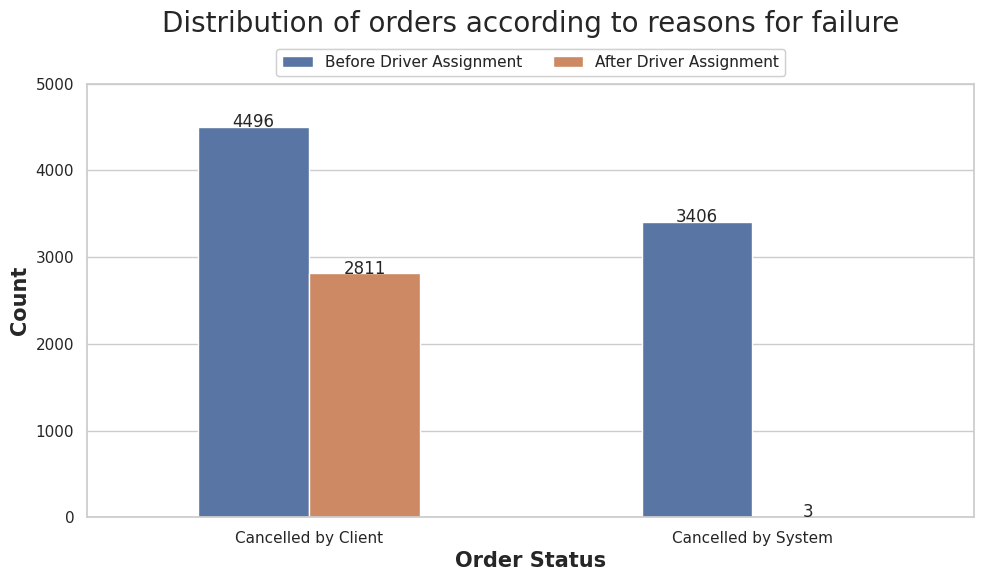

In [5]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

barplot = sns.barplot(x='order_status_key', y='count', 
                      hue='is_driver_assigned_key', data=reasons, width=0.5)
ax.set_title('Distribution of orders according to reasons for failure', fontsize=20, y=1.1)
ax.set_xlabel('Order Status', fontsize=15, fontweight='bold')
ax.set_ylabel('Count', fontsize=15, fontweight='bold')


for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        ax.text(x = p.get_x()+(p.get_width()/2), 
                y = height, 
                s = '{:.0f}'.format(height), 
                ha = 'center')

legend = ax.legend(bbox_to_anchor=(0.5, 1), loc='lower center', ncol=2, title='Driver Assigned')
legend.set_title(None)
ax.add_artist(legend)
plt.tight_layout()
plt.ylim(0, 5000)
plt.show()

# Q2

In [6]:
orders["order_datetime"] = pd.to_datetime(orders["order_datetime"])
orders["order_hour"] = orders["order_datetime"].dt.hour
def failure_reason(row):
    if (row["order_status_key"] == 4) & (row["is_driver_assigned_key"] == 0):
        return "Cancelled by client\nbefore driver assignment"
    elif (row["order_status_key"] == 4) & (row["is_driver_assigned_key"] == 1):
        return "Cancelled by client\nafter driver assignment"
    elif (row["order_status_key"] == 9) & (row["is_driver_assigned_key"] == 0):
        return "Cancelled by system\nbefore driver assignment"
    else:
        return "Cancelled by system\nafter driver assignment"
orders["failure_reason"] = orders.apply(failure_reason, axis=1)
failure_count = orders.pivot_table(index='order_hour', columns='failure_reason', aggfunc='size', fill_value=0).reset_index().rename_axis(None, axis=1)
failure_count['total_orders'] = failure_count[['Cancelled by client\nbefore driver assignment', 'Cancelled by client\nafter driver assignment', 'Cancelled by system\nbefore driver assignment', 'Cancelled by system\nafter driver assignment']].sum(axis=1)

failure_count.head(5)

,order_hour,Cancelled by client\nafter driver assignment,Cancelled by client\nbefore driver assignment,Cancelled by system\nafter driver assignment,Cancelled by system\nbefore driver assignment,total_orders
0,0,120,298,2,263,683
1,1,88,219,0,164,471
2,2,78,237,0,240,555
3,3,64,224,0,225,513
4,4,41,50,0,61,152


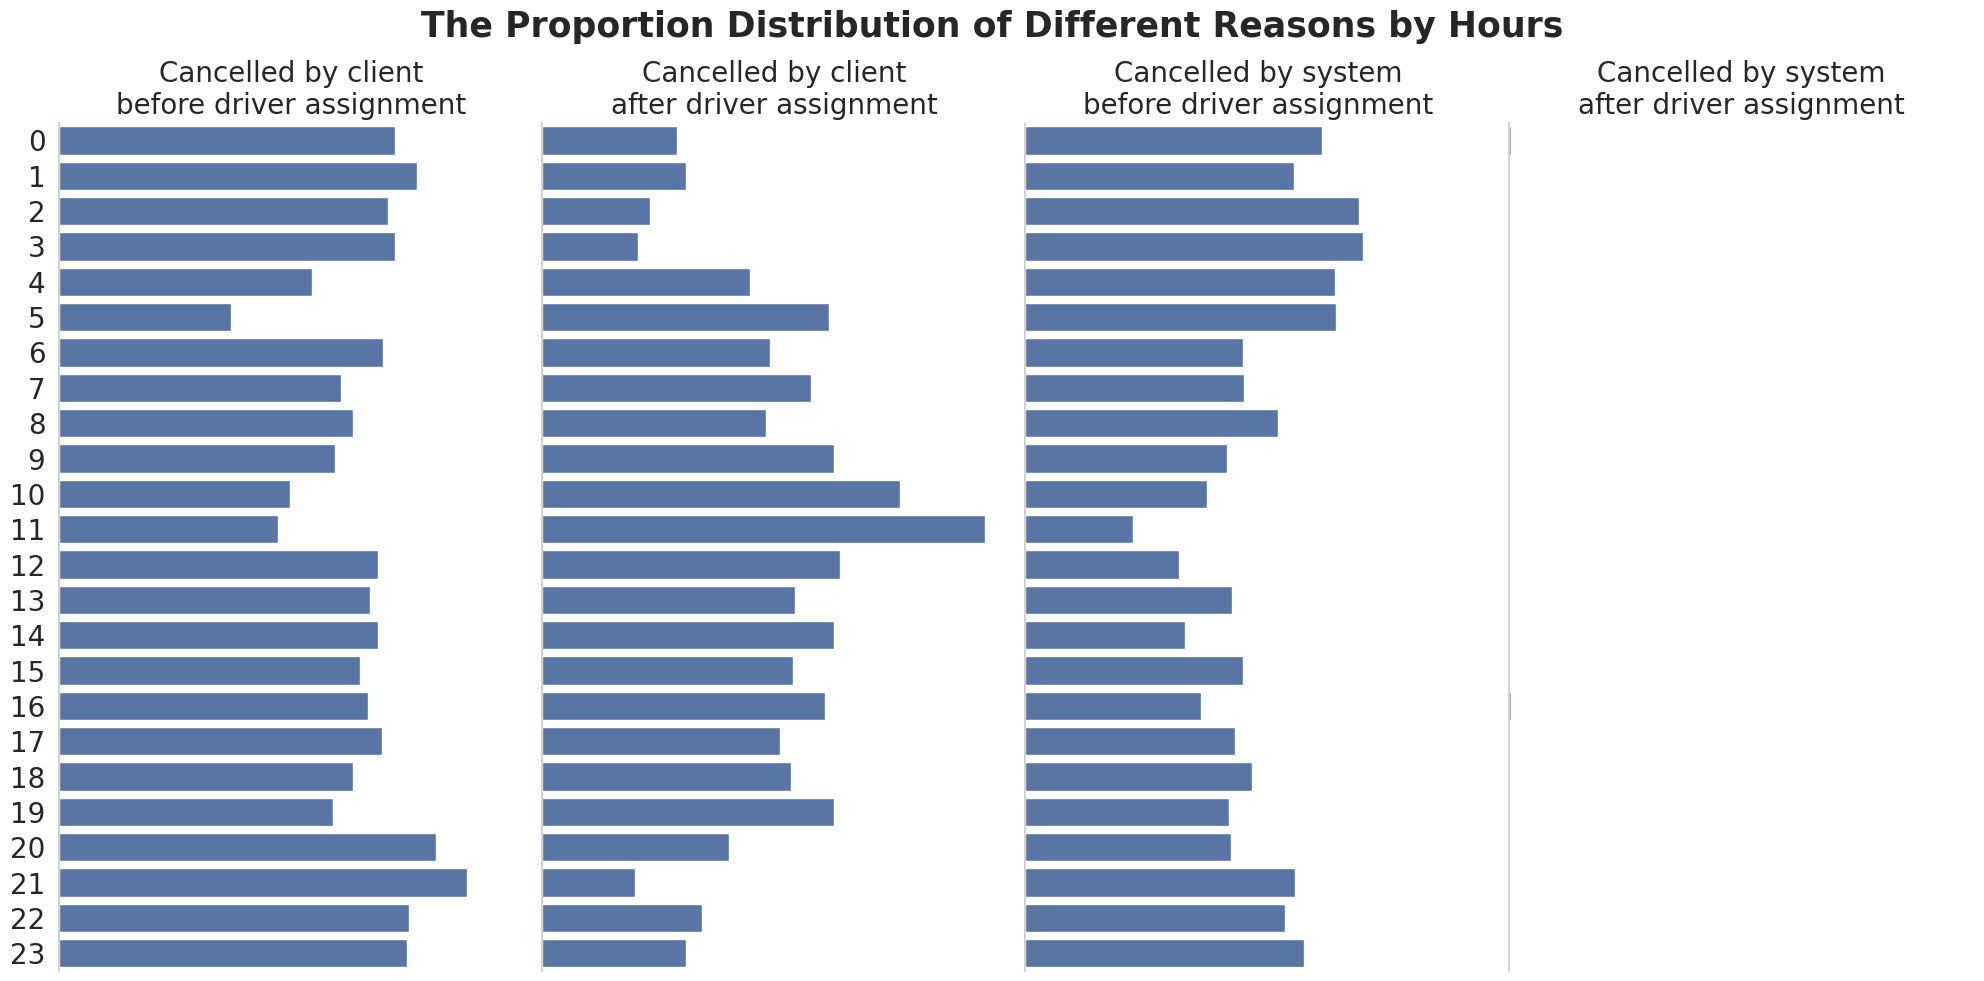

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(20,10), sharey=True, sharex=True)

columns=["Cancelled by client\nbefore driver assignment",
         "Cancelled by client\nafter driver assignment",
         "Cancelled by system\nbefore driver assignment",
         "Cancelled by system\nafter driver assignment"]

for i, ax in enumerate(axs):
    sns.barplot(x=failure_count[columns[i]]/failure_count["total_orders"], y=failure_count['order_hour'].astype(str), ax=ax)
    ax.set_title(columns[i], fontsize=20)
   
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.spines['left'].set_visible(True)
  
    ax.set_xticks([])
 
    ax.tick_params(axis='y', labelsize=20)
    ax.set_xlabel('')
    ax.set_ylabel('')

title_text = "The Proportion Distribution of Different Reasons by Hours"
fig.suptitle(title_text, fontsize=25, weight='bold')
plt.tight_layout()
plt.show()

In [8]:
# 定义四种颜色
color1 = '#FF5733'  # 橙色
color2 = '#33FF57'  # 绿色
color3 = '#5733FF'  # 蓝紫色
color4 = '#FF57B8'  # 粉红色

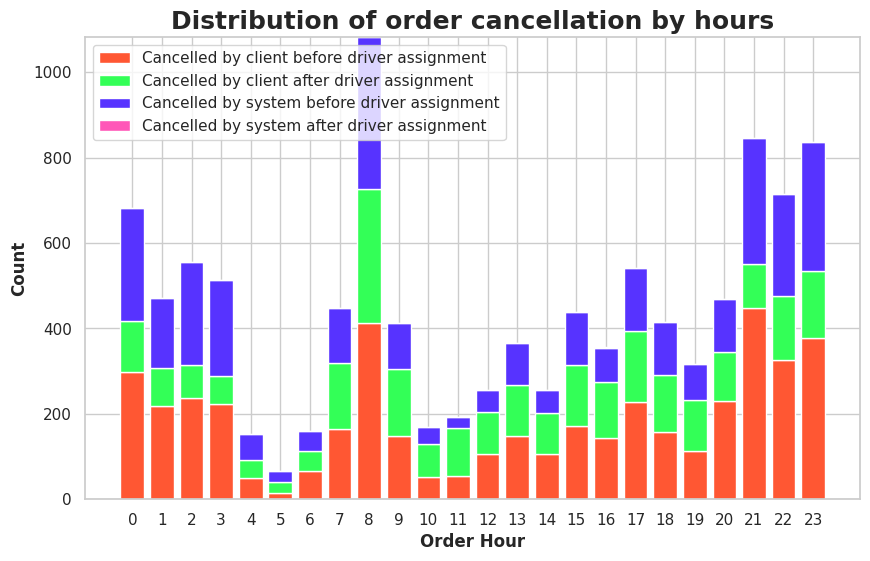

In [15]:
fig, ax = plt.subplots(figsize=(10,6))

bars = np.add(failure_count['Cancelled by client\nbefore driver assignment'], failure_count['Cancelled by client\nafter driver assignment']).tolist()
ax.bar(failure_count['order_hour'], failure_count['Cancelled by client\nbefore driver assignment'], color=color1, label='Cancelled by client before driver assignment')
ax.bar(failure_count['order_hour'], failure_count['Cancelled by client\nafter driver assignment'], bottom=failure_count['Cancelled by client\nbefore driver assignment'], color=color2, label='Cancelled by client after driver assignment')

ax.bar(failure_count['order_hour'], failure_count['Cancelled by system\nbefore driver assignment'], bottom=bars, color=color3, label='Cancelled by system before driver assignment')
bars = np.add(bars, failure_count['Cancelled by system\nbefore driver assignment']).tolist()

ax.bar(failure_count['order_hour'], failure_count['Cancelled by system\nafter driver assignment'], bottom=bars, color=color4, label='Cancelled by system after driver assignment')

ax.set_xlabel('Order Hour', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Distribution of order cancellation by hours',fontsize=18, fontweight='bold')
ax.set_xticks(range(24))
ax.legend()

plt.show()

# Q3

define a function to remove outliers

In [10]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_out = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_out

In [11]:
orders['order_hour'] = pd.to_datetime(orders['order_datetime']).dt.hour
Q3_before = orders[orders['is_driver_assigned_key']==0][['order_hour','cancellations_time_in_seconds']]
Q3_after = orders[orders['is_driver_assigned_key']==1][['order_hour','cancellations_time_in_seconds']]
Q3_before = remove_outliers(Q3_before,'cancellations_time_in_seconds').groupby(['order_hour'])['cancellations_time_in_seconds'].mean()
Q3_after = remove_outliers(Q3_after,'cancellations_time_in_seconds').groupby(['order_hour'])['cancellations_time_in_seconds'].mean()

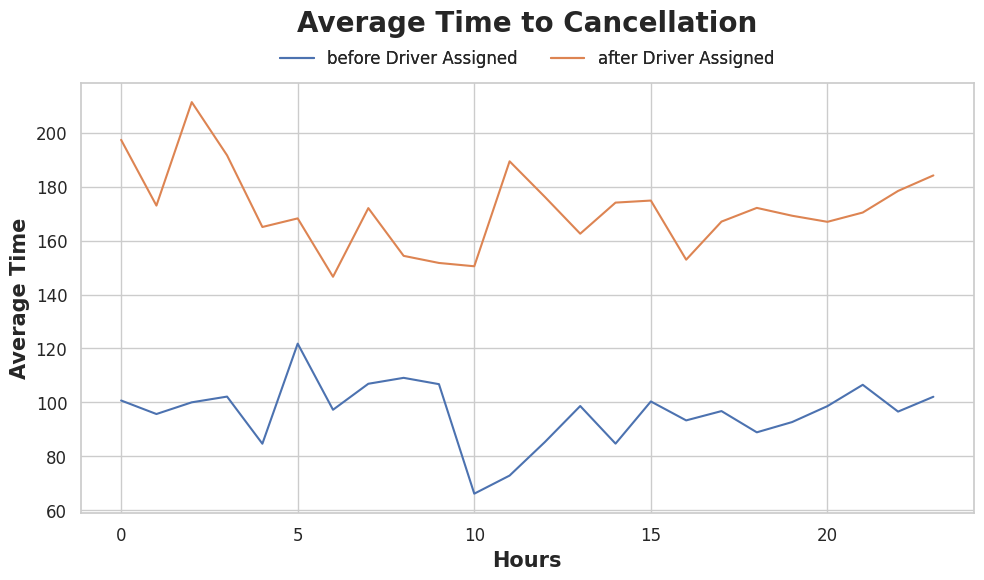

In [16]:
sns.set_theme(style='whitegrid')
colors = sns.color_palette("flare")

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=Q3_before, ax=ax, label='before Driver Assigned', markersize=5)
sns.lineplot(data=Q3_after, ax=ax, label='after Driver Assigned', markersize=5)

ax.set_title('Average Time to Cancellation', fontsize=20, y=1.1,fontweight='bold')
ax.set_xlabel('Hours', fontsize=15, fontweight='bold')
ax.set_ylabel('Average Time', fontsize=15, fontweight='bold')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

legend = ax.legend(bbox_to_anchor=(0.5, 1), loc='lower center', ncol=2, title='Driver Assigned', title_fontsize='13', fontsize='12',frameon=False)
legend.set_title(None)
ax.add_artist(legend)
plt.tight_layout()
plt.show()

# Q4

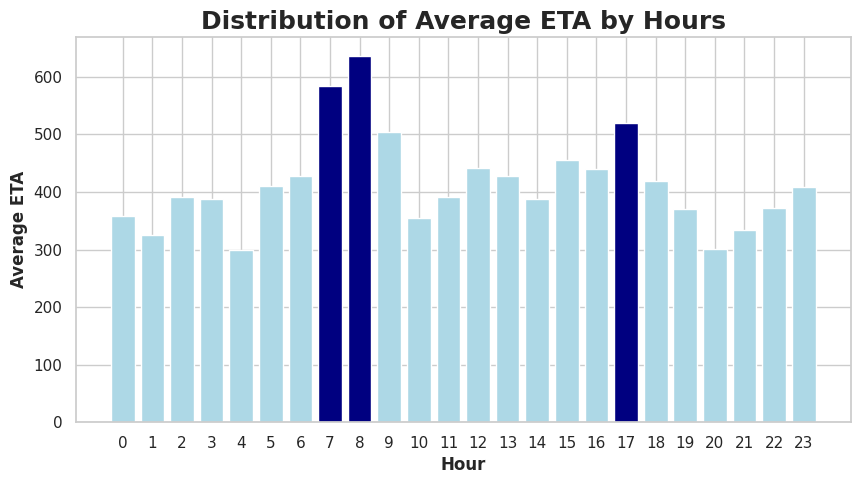

In [13]:
orders_nona = orders.dropna(subset=["m_order_eta"])
average_eta_by_hour = orders_nona.groupby('order_hour')['m_order_eta'].mean().reset_index()
top_hours = average_eta_by_hour.nlargest(3, 'm_order_eta')['order_hour']
colors = ['navy' if hour in top_hours.values else 'lightblue' for hour in average_eta_by_hour['order_hour']]

plt.figure(figsize=(10,5))
plt.bar(average_eta_by_hour['order_hour'], average_eta_by_hour['m_order_eta'], color=colors)
plt.title('Distribution of Average ETA by Hours', fontsize=18, fontweight='bold')
plt.xlabel('Hour', fontsize=12, fontweight='bold')
plt.ylabel('Average ETA', fontsize=12, fontweight='bold')
plt.xticks(range(0, 24))
plt.show()

# Q5

In [14]:
orders['h3_index'] = orders.apply(lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8), axis=1)

fail_counts = orders['h3_index'].value_counts().reset_index()
fail_counts.columns = ['h3_index', 'fail_count']

fail_counts = fail_counts.sort_values(by='fail_count', ascending=False)
fail_counts['cumulative_count'] = fail_counts['fail_count'].cumsum()
total_fails = fail_counts['fail_count'].sum()
fail_counts['cumulative_percent'] = 100 * fail_counts['cumulative_count'] / total_fails

over_80_index = fail_counts[fail_counts['cumulative_percent'] > 80].index[0]

hexes_80_percent = fail_counts.loc[:over_80_index, 'h3_index']

min_fail = fail_counts['fail_count'].min()
max_fail = fail_counts['fail_count'].max()
colormap = cm.LinearColormap(colors=['lightblue', 'darkblue'], vmin=min_fail, vmax=max_fail)

m = folium.Map(location=[orders['origin_latitude'].mean(), orders['origin_longitude'].mean()], zoom_start=13)

for index, row in fail_counts.iterrows():
    if row['h3_index'] in hexes_80_percent.values:
        hex_boundary = h3.h3_to_geo_boundary(row['h3_index'])
        color = colormap(row['fail_count'])
        folium.Polygon(locations=hex_boundary, color=color, fill=True, fill_color=color, fill_opacity=0.7).add_to(m)

colormap.add_to(m)

m